## GPT Overview  

[GPT (Generative Pre-trained Transformer)](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) is a family of autoregressive language models developed by OpenAI, beginning with GPT-1 in 2018. Its defining feature is the ability to generate coherent text by predicting the next token in a sequence using left-to-right context. This makes GPT particularly effective for Natural Language Generation (NLG), including dialogue systems, creative writing, and code synthesis.  

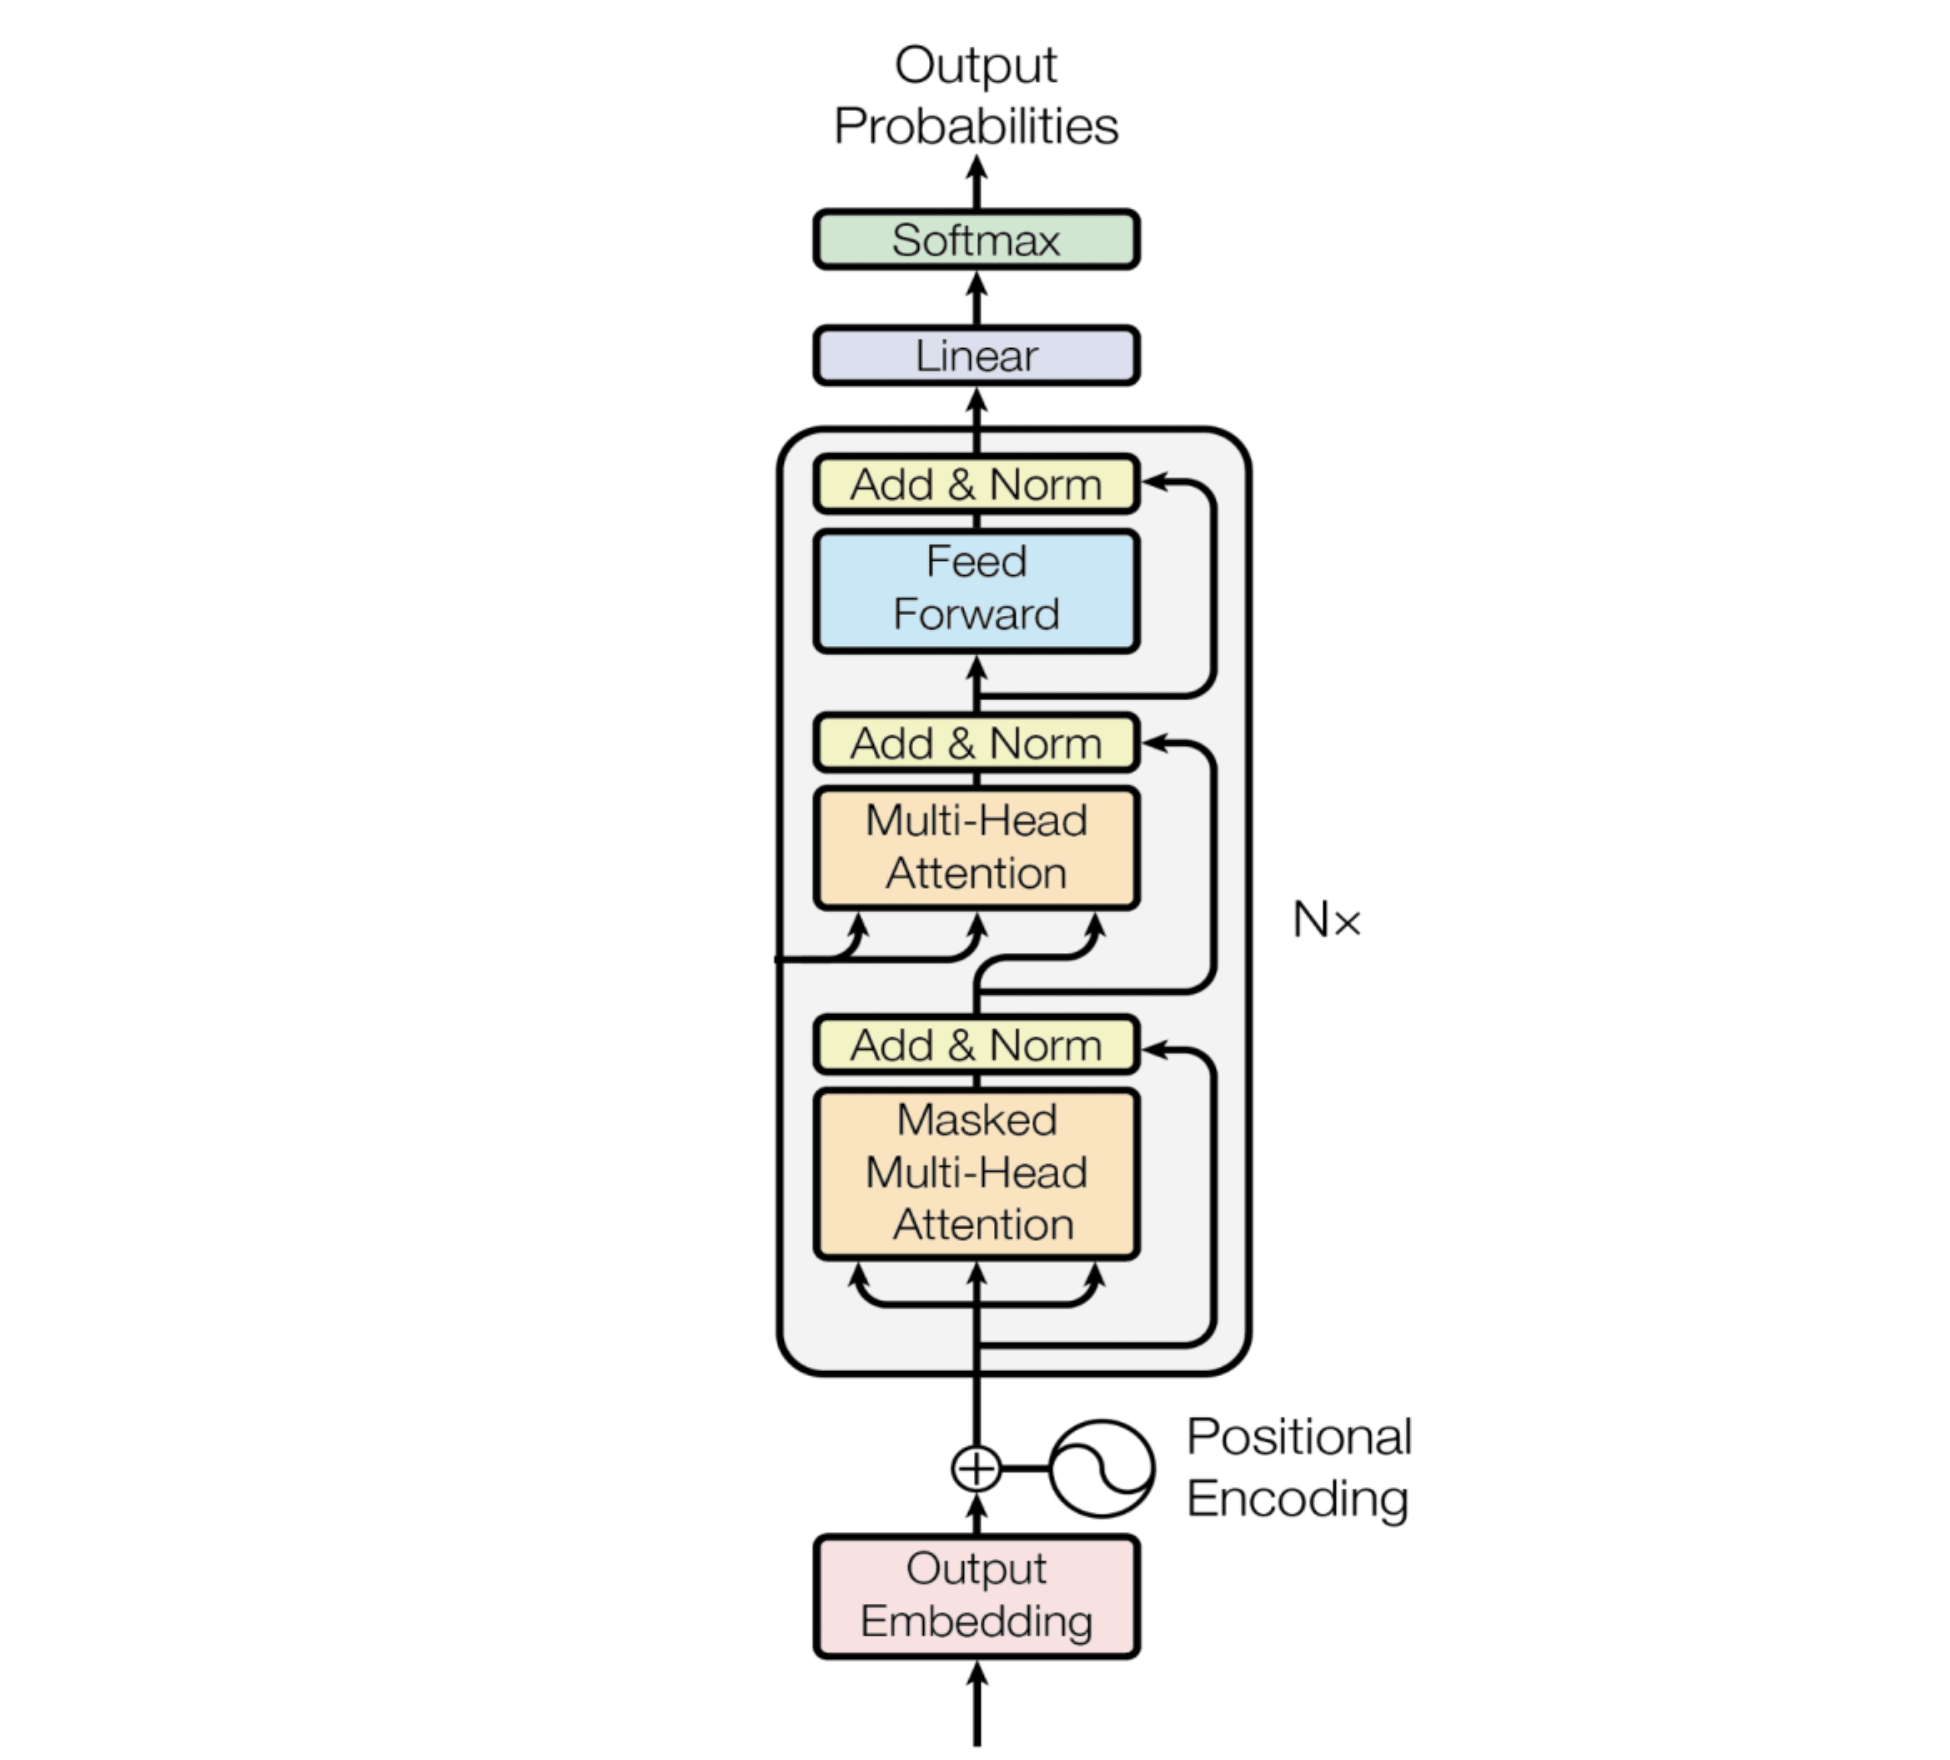

The architecture utilizes the Transformer’s decoder with masked self-attention layers, which restrict the model from attending to future tokens during training. Unlike bidirectional models like BERT, GPT processes text autoregressively, making it inherently suited for text generation but less optimal for tasks requiring full-sentence context analysis, such as named entity recognition (NER) or sentiment classification.  

### Pre-training Methodology  
GPT popularized autoregressive pre-training, where the model learns linguistic patterns by predicting the next word in a sequence across vast text corpora. During pre-training, GPT processes text strictly left-to-right, with each token attending only to previous tokens. This approach captures syntax, style, and factual knowledge but lacks bidirectional context.  

Training a task-specific model without pre-training is akin to teaching someone to write poetry without prior exposure to literature—laborious and prone to failure. GPT’s pre-training phase resembles training on diverse texts (books, articles, code), enabling it to generalize across tasks with minimal fine-tuning.   

This philosophy laid the groundwork for scaling the GPT series (GPT-2 in 2019, GPT-3 in 2020), with each iteration increasing parameters and training data to achieve stronger few-shot or zero-shot learning capabilities.  

---

### Fine-tuning Mechanics  
Early GPT models (e.g., GPT-1, GPT-2) require task-specific fine-tuning, such as adding a classification head for sentiment analysis. However, GPT-3 (175 billion parameters) demonstrated that sufficiently large models can perform tasks via prompt engineering alone without parameter updates.  

Key distinctions:  
- GPT-1/2: Fine-tuning on labeled data remains necessary for most applications.  
- GPT-3/4: Prompt-based few-shot learning reduces reliance on labeled examples, though fine-tuning is still used for specialized domains (e.g., medical or legal text generation).  

---

### Autoregressive Context  
GPT generates text sequentially, relying exclusively on leftward context. For example, given the prompt *“The sunset over the mountains was…”*, the model might predict *“a breathtaking spectacle of crimson and gold,”* unaware of any tokens to the right. This design ensures coherence in generation but limits bidirectional reasoning.  

Contrast with BERT:  
- BERT’s bidirectional processing excels at tasks like fill-in-the-blank (e.g., *“He cast his net near the riverbank to catch [MASK]”* → *“fish”*).  
- GPT cannot natively leverage future context, as its masked self-attention ensures each prediction depends only on past tokens.  

## GPT’s Architectural Design  

Unlike BERT’s bidirectional approach, GPT processes text sequentially—left to right—enabling coherent text generation but limiting access to future context. Its design prioritizes scalability, with each iteration (GPT-1 in 2018, GPT-2 in 2019, GPT-3 in 2020, GPT-4) exponentially increasing parameters and training data.  

### Core Pre-training Objective: Next Token Prediction  
GPT’s foundational task is autoregressive language modeling, where the model predicts the next token in a sequence using only preceding context. This unidirectional approach mirrors human text generation but contrasts with BERT’s masked bidirectional training.  

Key Papers:  
- GPT-1 (*"Improving Language Understanding by Generative Pre-Training"*, 2018): Introduced task-agnostic pre-training followed by task-specific fine-tuning.  
- GPT-2 (*"Language Models are Unsupervised Multitask Learners"*, 2019): Scaled parameters (1.5B) and demonstrated zero-shot task transfer without fine-tuning.  
- GPT-3 (*"Language Models are Few-Shot Learners"*, 2020): Achieved few-shot learning with 175B parameters, reducing reliance on labeled data.  

---

### Autoregressive Pre-training Mechanics  
GPT’s decoder employs **masked self-attention**, preventing the model from attending to future tokens during training. Each layer processes the sequence iteratively, refining predictions based on leftward context.  

#### Training Data & Tokenization:  
- Tokenization: Uses byte-pair encoding (BPE) to handle rare words (e.g., "tokenization" → "token-ization"). Vocabulary sizes vary: GPT-2 (50,257 tokens), GPT-3 (50,257).  
- Вatasets: Trained on diverse corpora:  
  - GPT-1: BooksCorpus (~7,000 unpublished books).  
  - GPT-2: WebText (8 million web pages).  
  - GPT-3: Common Crawl, WebText2, books, Wikipedia (45TB total).  

#### Positional Embeddings:  
Unlike BERT’s fixed positional vectors, GPT uses learned positional embeddings, allowing flexibility in sequence length up to model limits (e.g., 2,048 tokens for GPT-3).  

---

### Model Variants & Scaling  

| **Model** | Parameters | Layers | Attention Heads | Embedding Dim | Training Data |  
|-----------|------------|--------|-----------------|---------------|---------------|  
| GPT-1     | 117M       | 12     | 12              | 768           | BooksCorpus   |  
| GPT-2     | 1.5B       | 48     | 25              | 1,600         | WebText       |  
| GPT-3     | 175B       | 96     | 96              | 12,288        | Mixed Corpus  |  
| GPT-4     | ~1.7T*     | 120+   | 128+            | 20,480+       | Proprietary   |  

*Estimated. GPT-4’s architecture remains undisclosed but emphasizes sparse attention for efficiency.  

Scaling Laws: OpenAI’s research highlights that performance scales predictably with model size, data, and compute. 

---

### Task Adaptation: From Fine-tuning to Prompt Engineering  

#### Early GPT (1/2): Task-Specific Fine-tuning  
- Mechanism: Add task-specific layers (e.g., classification head) and update all parameters.  
- Example: For sentiment analysis, append a linear layer to GPT-1’s final token output.  

#### GPT-3/4: In-Context Learning  
- Prompt Engineering: Tasks are framed as text completions via natural language prompts (e.g., *“Translate to French: [text]”*).  
- Few-Shot Learning: Provide 1–10 examples in the prompt to guide outputs without parameter updates.  

---

### Specialized Tokens & Input Formatting  
GPT’s token system is simpler than BERT’s, focusing on generation:  
- [PAD]: Padding for batch processing (rarely used in later models).  
- [UNK]: Represents out-of-vocabulary terms.  
- [SEP]: Used in multi-task fine-tuning (e.g., GPT-1 for QA tasks).  

**Input Structure**: Single sequence format (no segment embeddings), with tasks like QA adapted via delimiter tokens (e.g., *“Question: [Q]? Answer: [A]”*).  

## Environment Set Up

In [ ]:
!pip install -q transformers datasets evaluate accelerate bitsandbytes sentencepiece
!pip install -q loralib peft tensorboard

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
import evaluate
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    TrainingArguments, 
    Trainer,
    DataCollatorForLanguageModeling,
    GPT2Config
)
from tqdm import tqdm

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
if torch.cuda.is_available():
    print(f"GPU memory avaliable: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} ГБ")

## Dataset and Task
 
The notebook uses the **RuCoS** (Russian Commonsense Reasoning) dataset, part of the Russian SuperGLUE benchmark. This task evaluates a model’s ability to fill in missing information (`@placeholder`) in questions based on a provided text passage. Each example contains:  
- A passage describing real-world scenarios (e.g., historical events, everyday situations).  
- Multiple question-answer pairs where the question has a `@placeholder` to be filled using contextual clues from the passage.  
- Answers that require commonsense reasoning and understanding of Russian linguistic nuances.  

For instance, given a passage about fishing techniques, a question might be: *"He cast his net near the riverbank to catch @placeholder."*  

The model must infer the correct answer (e.g., "fish") from context. The dataset structure includes nested JSON objects with passages, questions, and answer lists, requiring careful data preprocessing to extract training pairs.  

## Preparing Data

In [ ]:
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [ ]:
train_data = read_jsonl('/kaggle/input/rucos-russian-superglue/RuCoS/train.jsonl')
valid_data = read_jsonl('/kaggle/input/rucos-russian-superglue/RuCoS/val.jsonl')

print(f"Train examples: {len(train_data)}")
print(f"Test examples: {len(valid_data)}")

In [ ]:
print("\nExample from dataset:")
example = train_data[0]
for key in example.keys():
    print(f"{key}: {type(example[key])}")

In [ ]:
print("\nExample passage text:")
if isinstance(example['passage'], dict) and 'text' in example['passage']:
    print(example['passage']['text'][:300], "...")
else:
    print("Passage structure is different than expected")

In [ ]:
print("\nExample query:")
if 'qas' in example and len(example['qas']) > 0 and 'query' in example['qas'][0]:
    print(example['qas'][0]['query'])
else:
    print("Query structure is different than expected")

In [ ]:
print("\nExample target answers:")
if 'qas' in example and len(example['qas']) > 0 and 'answers' in example['qas'][0]:
    print(example['qas'][0]['answers'])
else:
    print("Answers structure is different than expected")

In [ ]:
def prepare_data_for_gpt(data):
    prepared_data = []
    
    for item in tqdm(data):
        if not (isinstance(item, dict) and 'passage' in item and 'qas' in item):
            continue
            
        if isinstance(item['passage'], dict) and 'text' in item['passage']:
            passage = item['passage']['text']
        elif isinstance(item['passage'], str):
            passage = item['passage']
        else:
            continue
            
        for qa in item['qas']:
            if not (isinstance(qa, dict) and 'query' in qa and 'answers' in qa):
                continue
                
            query = qa['query']
            answers = qa['answers']
            
            # Create prompt template for cloze task
            prompt = f"Read the text and fill in the @placeholder in the question.\n\nText: {passage}\n\nQuestion: {query}\n\nAnswer:"
            
            # Use first answer if multiple are available, ensure it's a string
            completion = ""
            if answers and isinstance(answers, list) and len(answers) > 0:
                if isinstance(answers[0], str):
                    completion = answers[0]
                elif isinstance(answers[0], dict) and 'text' in answers[0]:
                    completion = answers[0]['text']
            
            prepared_data.append({
                "prompt": prompt,
                "completion": completion,
                "passage_id": item.get('idx', ''),
                "query_id": qa.get('idx', '')
            })
    
    return prepared_data

In [ ]:
train_prepared = prepare_data_for_gpt(train_data)
valid_prepared = prepare_data_for_gpt(valid_data)

In [ ]:
train_dataset = Dataset.from_pandas(pd.DataFrame(train_prepared))
valid_dataset = Dataset.from_pandas(pd.DataFrame(valid_prepared))

print(f"Prepared training data: {len(train_dataset)} examples")
print(f"Prepared validation data: {len(valid_dataset)} examples")

## Classical Fine-Tuning

This notebook uses classical full fine-tuning (updating all model parameters) primarily for educational transparency. 

While methods like LoRA (Low-Rank Adaptation) are popular for efficiency, classical fine-tuning offers:  
- Clear learning dynamics: Observing how all layers adapt helps beginners understand model behavior.  
- Simplicity: No additional adapter layers or complex configurations.  
- Reproducibility: Full parameter updates align with standard research practices.  

However, LoRA is often better for production. Below is a simplified comparison:  

| Method          | Parameters Updated | GPU Memory | Educational Value | Overfitting Risk | Best For          |  
|-----------------|--------------------|------------|-------------------|------------------|-------------------|  
| Classical FT    | All (100%)         | High       | High              | Moderate         | Small models, education |  
| LoRA            | ~1-5%              | Low        | Medium            | Low              | Large models, efficiency |  

Classical fine-tuning is chosen here to demonstrate core concepts, but learners should explore LoRA for real-world applications with large models. The choice depends on your goals: education vs. efficiency, small vs. large models, and available hardware.

## Model and Tokenizer

In [ ]:
model_name = "ai-forever/rugpt3small_based_on_gpt2"  # We gonna use smaller model for classic fine-tuning

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

In [ ]:
model = model.to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model):,}")

In [ ]:
param_size = count_parameters(model) * 4 
print(f"Estimated model size in memory: {param_size / 1024**3:.2f} GB")

In [ ]:
def tokenize_function(examples):
    max_length = 384
    
    texts = []
    for prompt, completion in zip(examples["prompt"], examples["completion"]):
        prompt_str = str(prompt) if prompt is not None else ""
        completion_str = str(completion) if completion is not None else ""
        texts.append(prompt_str + " " + completion_str)
    
    tokenized = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    
    # Create labels (identical to input IDs as this is causal language modeling)
    tokenized["labels"] = tokenized["input_ids"].copy()
    
    return tokenized

In [ ]:
train_tokenized = train_dataset.map(
    tokenize_function, 
    batched=True, 
    batch_size=64, 
    remove_columns=train_dataset.column_names
)

valid_tokenized = valid_dataset.map(
    tokenize_function, 
    batched=True, 
    batch_size=64,
    remove_columns=valid_dataset.column_names
)

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # For autoregressive models (GPT) use mlm=False
)

## Classic Fine-Tuning

In [ ]:
output_dir = "./results_classic"

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,         # Small batch size to save memory
    per_device_eval_batch_size=2,          # Small batch size for validation
    gradient_accumulation_steps=16,        # Increase effective batch size through gradient accumulation
    eval_accumulation_steps=16,            # Same for validation
    eval_strategy="steps",                 # Corrected from 'evaluation_strategy' to 'eval_strategy'
    eval_steps=100,                        # Evaluation frequency
    logging_steps=10,                      # Logging steps
    learning_rate=2e-5,                    # Lower learning rate for classic method
    weight_decay=0.01,                     # Weight regularization
    warmup_steps=100,                      # Gradual learning rate increase
    save_steps=500,                        # How often to save model
    load_best_model_at_end=True,           # Load best model at the end
    num_train_epochs=2,                    # Fewer epochs due to full parameter updates
    fp16=True,                             # Use mixed precision to save memory
    report_to="tensorboard",               # Use TensorBoard for logging
    save_total_limit=2,                    # Save only last 2 checkpoints to save space
    push_to_hub=False,                     # Don't upload to Hugging Face Hub
    # Optimizations for classic method on limited GPU
    gradient_checkpointing=True,           # Save memory at the cost of computation
    optim="adamw_torch",                   # Use AdamW optimizer
    bf16=False,                            # Some GPUs support bf16 instead of fp16
    max_grad_norm=1.0,                     # Limit gradient for stability
)

In [ ]:
print("\n=== Pre-training checks ===")
print(f"Training set size: {len(train_tokenized)}")
print(f"Validation set size: {len(valid_tokenized)}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.train()

## Generation and Evaluation

In [ ]:
def generate_answer(model, tokenizer, passage, query, max_length=50):
    prompt = f"Read the text and fill in the @placeholder in the question.\n\nText: {passage}\n\nQuestion: {query}\n\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # For memory savings, use do_sample=True instead of beam search
    output = model.generate(
        inputs["input_ids"],
        max_new_tokens=max_length,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        no_repeat_ngram_size=2
    )
    
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    answer = decoded[len(prompt):].strip()
    
    return answer

In [ ]:
def evaluate_model(model, tokenizer, valid_data, n_samples=100):
    exact_matches = 0
    samples = valid_data[:n_samples] if n_samples < len(valid_data) else valid_data
    
    results = []
    
    for item in tqdm(samples):
        if not (isinstance(item, dict) and 'passage' in item and 'qas' in item and len(item['qas']) > 0):
            continue
            
        if isinstance(item['passage'], dict) and 'text' in item['passage']:
            passage = item['passage']['text']
        elif isinstance(item['passage'], str):
            passage = item['passage']
        else:
            continue
            
        for qa in item['qas']:
            if not (isinstance(qa, dict) and 'query' in qa and 'answers' in qa):
                continue
                
            query = qa['query']
            gold_answers = qa['answers']
            
            string_gold_answers = []
            for ans in gold_answers:
                if isinstance(ans, str):
                    string_gold_answers.append(ans)
                elif isinstance(ans, dict) and 'text' in ans:
                    string_gold_answers.append(ans['text'])
            
            pred_answer = generate_answer(model, tokenizer, passage, query)
            
            exact_match = any(pred_answer.lower() == ans.lower() for ans in string_gold_answers) if string_gold_answers else False
            if exact_match:
                exact_matches += 1

            results.append({
                "passage": passage[:200] + "...",  # Save only beginning to save space
                "query": query,
                "gold_answers": string_gold_answers,
                "pred_answer": pred_answer,
                "exact_match": exact_match
            })
    
    accuracy = exact_matches / len(results) if results else 0
    print(f"Accuracy (Exact Match): {accuracy:.4f}")
    
    return results, accuracy

In [ ]:
# Clear cache again before evaluation
gc.collect()
torch.cuda.empty_cache()

In [ ]:
eval_results, accuracy = evaluate_model(model, tokenizer, valid_data, n_samples=50)

In [ ]:
eval_df = pd.DataFrame(eval_results)
eval_df.to_csv("evaluation_results_classic.csv", index=False)

In [ ]:
model_save_path = "./rucos_gpt_classic_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

In [ ]:
def use_finetuned_model(text_passage, query):
    saved_model = AutoModelForCausalLM.from_pretrained(
        model_save_path,
        device_map="auto",
        trust_remote_code=True
    )
    saved_tokenizer = AutoTokenizer.from_pretrained(model_save_path)
    
    answer = generate_answer(saved_model, saved_tokenizer, text_passage, query)
    
    return answer

In [ ]:
sample_item = valid_data[0]
if isinstance(sample_item['passage'], dict) and 'text' in sample_item['passage']:
    sample_passage = sample_item['passage']['text']
else:
    sample_passage = sample_item['passage']

if 'qas' in sample_item and len(sample_item['qas']) > 0 and 'query' in sample_item['qas'][0]:
    sample_query = sample_item['qas'][0]['query']
    sample_answers = sample_item['qas'][0]['answers']
else:
    sample_query = "Sample query with @placeholder"
    sample_answers = ["Sample answer"]

print("Example text:")
print(sample_passage[:200], "...\n")
print("Example question:")
print(sample_query)

In [ ]:
prediction = generate_answer(model, tokenizer, sample_passage, sample_query)
print(f"\nModel prediction: {prediction}")
print(f"Gold answers: {sample_answers}")